<h2 style="text-align:center;font-size:200%;;">Лаб 1</h2>

# **1. Подготовка данных** <a class="anchor" id="1"></a>

Импорты.


In [131]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline


In [132]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct, count, when
from pyspark.sql.types import *


Инициализация Спарка.


In [133]:

MAX_MEMORY = '5G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'data/archive/daily_dataset.csv'
# Load the main data set into pyspark data frame 
df = spark.read.csv(filename_data, sep=',', header=True, inferSchema = True)
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


# **2. Обзор датасета** <a class="anchor" id="2"></a>


In [134]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- LCLid: string (nullable = true)
 |-- day: date (nullable = true)
 |-- energy_median: double (nullable = true)
 |-- energy_mean: double (nullable = true)
 |-- energy_max: double (nullable = true)
 |-- energy_count: integer (nullable = true)
 |-- energy_std: double (nullable = true)
 |-- energy_sum: double (nullable = true)
 |-- energy_min: double (nullable = true)

Columns overview


,Column Name,Data type
0,LCLid,string
1,day,date
2,energy_median,double
3,energy_mean,double
4,energy_max,double
5,energy_count,int
6,energy_std,double
7,energy_sum,double
8,energy_min,double


In [135]:
print('Data frame describe:')
df.describe().toPandas()

print(f'There are total {df.count()} row, Let print first 5 data rows:')
df.limit(5).toPandas()

Data frame describe:


,summary,LCLid,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,count,3510433,3510403,3510403,3510403,3510433,3499102,3510403,3510403
1,mean,None,0.15873946509829392,0.2117304779734248,0.8345209600999659,47.80363590474452,0.17266728196750777,10.124143383647203,0.05962578028867954
2,stddev,None,0.17018645200367447,0.19084600034043936,0.6683155999769643,2.810982390150965,0.15312080847034248,9.128793404949802,0.08701311627503007
3,min,MAC000002,0.0,0.0,0.0,0,0.0,0.0,0.0
4,max,MAC005567,6.970500200000001,6.928250020833329,10.7609997,48,4.0245693445140125,332.5560009999998,6.5240002


There are total 3510433 row, Let print first 5 data rows:


,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066


# **3. Очистка данных** <a class="anchor" id="3"></a>

Обзор столбцов

In [119]:
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,LCLid,string
1,day,date
2,energy_median,double
3,energy_mean,double
4,energy_max,double
5,energy_count,int
6,energy_std,double
7,energy_sum,double
8,energy_min,double


## Очистка от пустых значений
"LCLid", "day" - отбрасываются

In [120]:

#string_columns = ['LCLid', 'sport', 'url']
df = df.drop("LCLid", "day")
numeric_columns = ['energy_median','energy_mean','energy_max','energy_count','energy_std','energy_sum','energy_min']
#date_columns = ['day']

#подсчет нулевых значений
missing_values = {} 
for index, column in enumerate(df.columns):
    if column in numeric_columns:  # check None, NaN
        missing_count = df.where(col(column).isin([None,np.nan]) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df
print(f'There are total {df.count()}')

#очистка
clear_df = df.dropna()

#проверка результатов
missing_values = {} 
for index, column in enumerate(clear_df.columns):
    if column in numeric_columns:  # check None, NaN
        missing_count = clear_df.where(col(column).isin([None,np.nan])).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df
print(f'There are total {clear_df.count()}')

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,30,30,30,0,11331,30,30


There are total 3510433


,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,0,0,0,0,0,0,0


There are total 3499102


## Графики выбросов

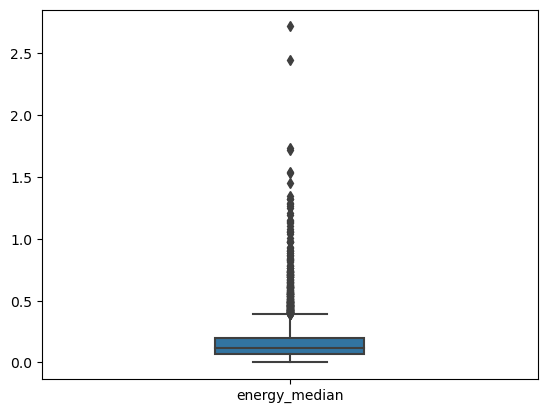

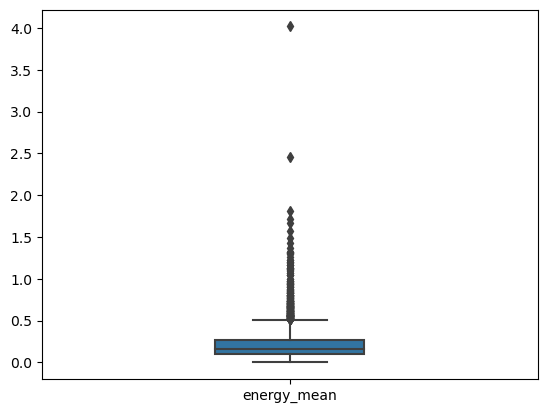

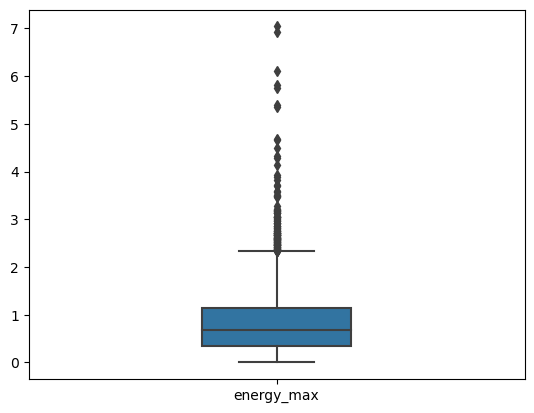

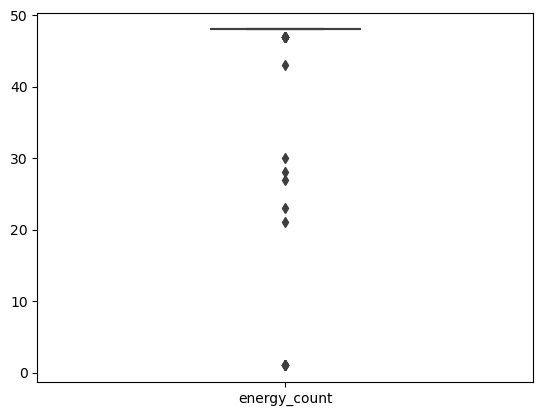

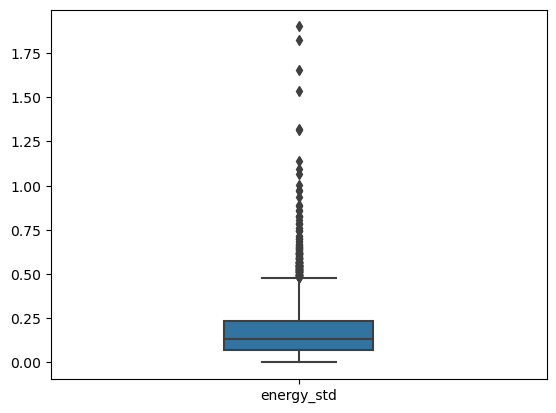

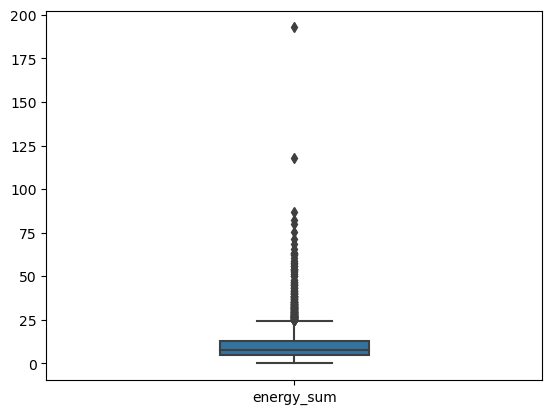

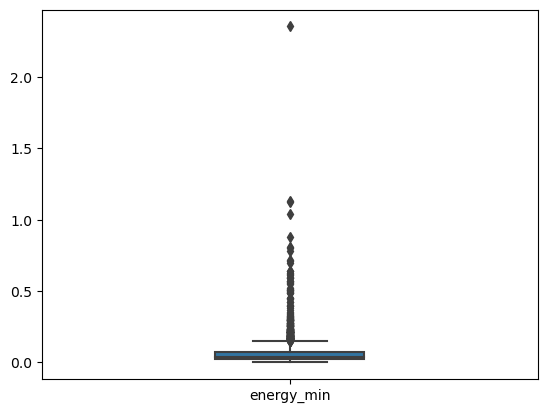

In [13]:
#plt = df.select(df.columns).toPandas().boxplot(df.columns, fontsize='small', figsize=(20,7))

def show_boxplot(df):
    for column in df.columns: 
        column_df = df.select(column).toPandas()
        sns.boxplot(column_df, width = 0.3)
        plt.show()

df_sample = df.sample(True, 0.001, 1)
show_boxplot(df_sample)

In [121]:
#определение квантилей
bounds = {
    c: dict(
        zip(["q1", "q3"], clear_df.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in clear_df.columns
}
for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)
print(bounds)


{'energy_median': {'q1': 0.067, 'q3': 0.191, 'lower': -0.119, 'upper': 0.377}, 'energy_mean': {'q1': 0.0982708333333333, 'q3': 0.2626041666666667, 'lower': -0.1482291666666668, 'upper': 0.5091041666666668}, 'energy_max': {'q1': 0.348, 'q3': 1.13, 'lower': -0.8249999999999998, 'upper': 2.303}, 'energy_count': {'q1': 48.0, 'q3': 48.0, 'lower': 48.0, 'upper': 48.0}, 'energy_std': {'q1': 0.06911625523412457, 'q3': 0.2293124542723251, 'lower': -0.17117804332317624, 'upper': 0.46960675282962594}, 'energy_sum': {'q1': 4.7109999999999985, 'q3': 12.591, 'lower': -7.109000000000002, 'upper': 24.411}, 'energy_min': {'q1': 0.02, 'q3': 0.071, 'lower': -0.05649999999999998, 'upper': 0.14749999999999996}}


In [123]:
#заменяем выбросы на пустые значения

clear_df = clear_df.select(
    [
        f.when(
            f.col(c).between(bounds[c]['lower'], bounds[c]['upper']), f.col(c)
        ).otherwise(None).alias(c)
        for c in df.columns
    ]
)
clear_df.show()

+-------------------+-------------------+------------------+------------+-------------------+------------------+-------------------+
|      energy_median|        energy_mean|        energy_max|energy_count|         energy_std|        energy_sum|         energy_min|
+-------------------+-------------------+------------------+------------+-------------------+------------------+-------------------+
|               null|0.43204545454545457|             0.868|        null|0.23914579678767536|             9.505|0.07200000000000001|
|             0.1415|0.29616666875000003|         1.1160001|          48| 0.2814713178628203|14.216000100000002|              0.031|
|             0.1015|          0.1898125|             0.685|          48| 0.1884046862418033|             9.111|              0.064|
|              0.114| 0.2189791666666666|0.6759999999999999|          48|0.20291927853038208|10.510999999999996|              0.065|
|              0.191|0.32597916666666665|0.7879999999999999|         

In [124]:
#удаляем выбросы

clear_df = clear_df.dropna()

## Графики выбросов после очистки данных

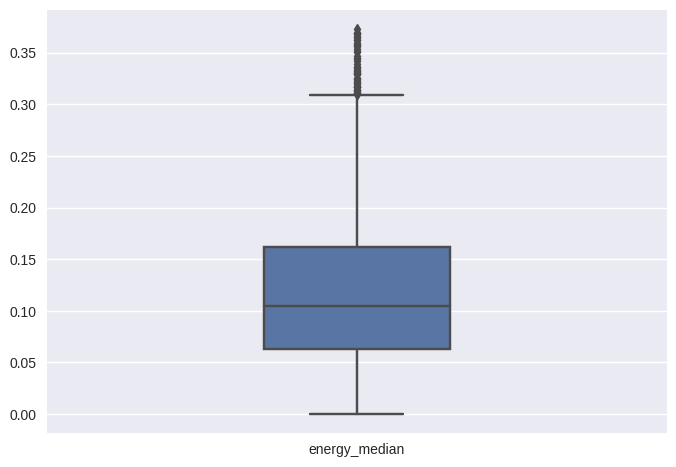

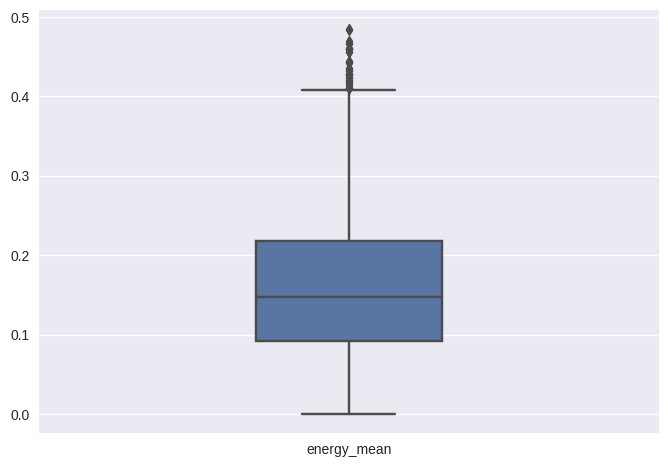

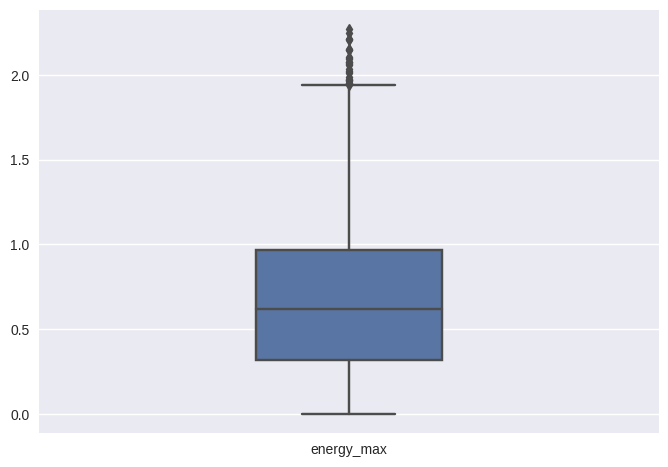

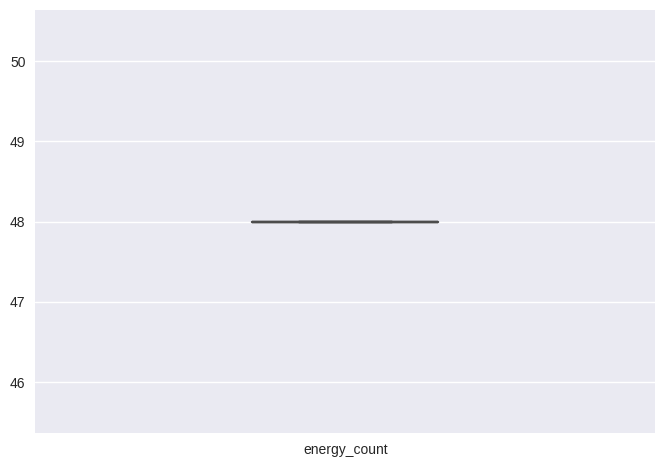

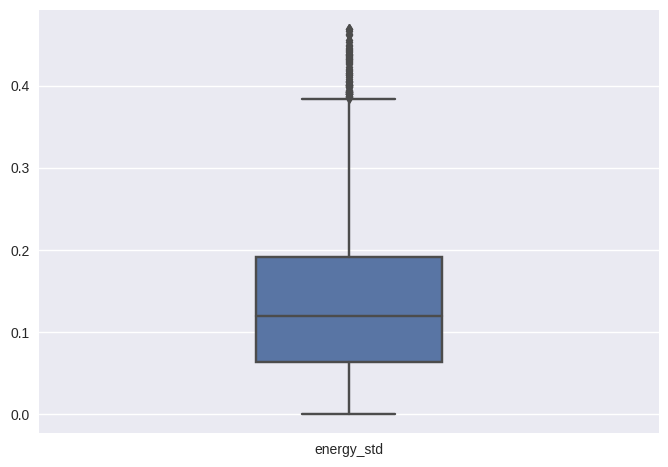

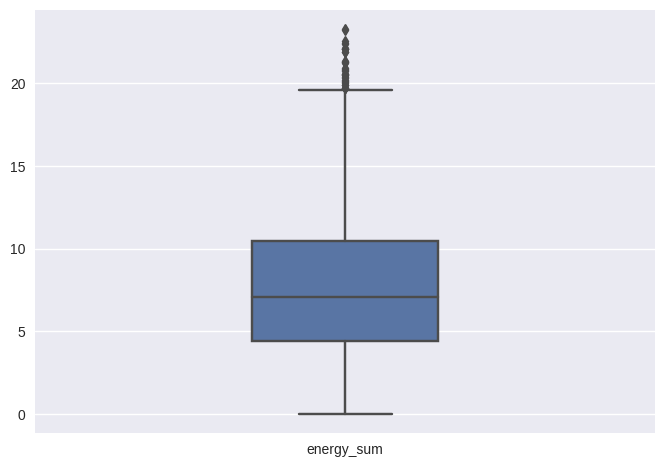

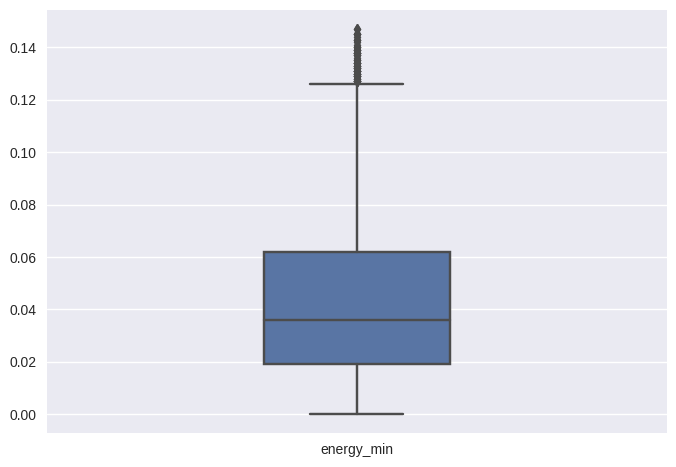

In [125]:

def show_boxplot(clear_df):
    for column in clear_df.columns: 
        column_df = clear_df.select(column).toPandas()
        sns.boxplot(column_df, width = 0.3)
        plt.show()

df_sample = clear_df.sample(True, 0.001, 1)
show_boxplot(df_sample)

# **4. Анализ данных** <a class="anchor" id="3"></a>

Расчет корреляции между параметрами

<Axes: >

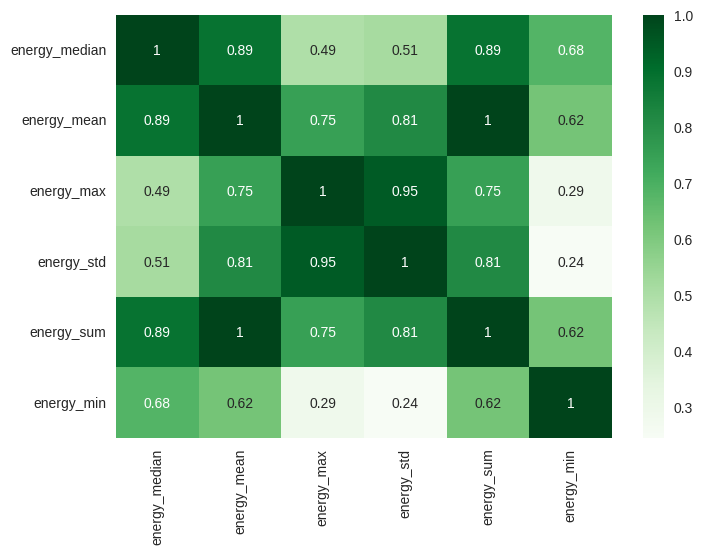

In [127]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# принимаем energy_count как константу, отбрасываем
clear_df = clear_df.drop("energy_count")

# сначала преобразуем данные в объект типа Vector
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=clear_df.columns, outputCol=vector_col)
df_vector = assembler.transform(clear_df).select(vector_col)

# получаем матрицу корреляции и тут же преобразуем данные в numpy вектор
matrix = Correlation.corr(df_vector, vector_col)
matrix = matrix.collect()[0][matrix.columns[0]].toArray()
# оборачиваем полученную корреляционную матрицу в pandas DataFrame
corr_matrix_df = pd.DataFrame(data=matrix, columns = clear_df.columns, index=clear_df.columns) 
  
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)
plt.show()

## Диаграммы распределения признаков

array([[<Axes: title={'center': 'energy_median'}>,
        <Axes: title={'center': 'energy_mean'}>,
        <Axes: title={'center': 'energy_max'}>],
       [<Axes: title={'center': 'energy_std'}>,
        <Axes: title={'center': 'energy_sum'}>,
        <Axes: title={'center': 'energy_min'}>]], dtype=object)

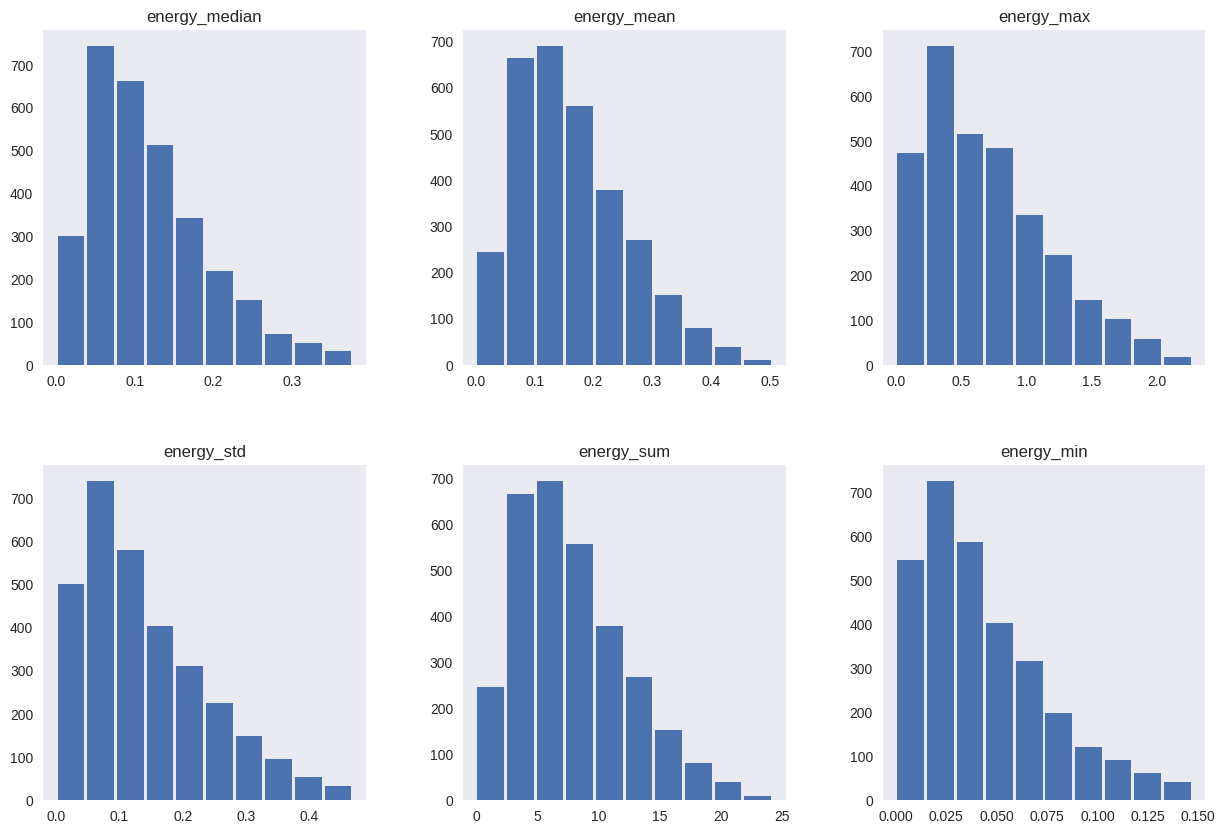

In [112]:
df_sample = clear_df.sample(True, 0.001, 1)
df_sample.toPandas().hist(figsize = (15,10), grid=False , layout = (2,3), rwidth = 0.9)

In [113]:
clear_df.toPandas().to_csv('data/archive/clear_daily_dataset.csv', index=False)